Author: Zidong Chen

Date:2024/07/04

Introduction

With the advancement of hardware technology, leveraging GPUs for parallel computing in Gaussian processes has become a prominent question. After significant progress in developing scalable GP models, I am excited to introduce a new inference method for standard Gaussian processes that enables GPU acceleration. This method allows for training exact Gaussian processes with thousands of data points in seconds, using just a single GPU on a laptop.


In [1]:
import os
import time
import sys
sys.path.append('..')  # Add parent folder to sys.path

import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from data_sample import generate_example_data as data
from cigp_v10 import cigp
# from torch.autograd import Variable
import torch.optim as optim
from kernel import ARDKernel
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1416

2.2.1


In standard Gaussian process, the negative log likelihood is given by:
$$-L=\frac{1}{2}y^T\Sigma^{-1}y+\frac{1}{2}log(|\Sigma|)+\frac{n}{2}log(2\pi)$$
Where$\Sigma = K(X,X)+ \frac{1}{\beta} I$, normally we compute the inverse of $\Sigma$ using Cholesky decomposition, which requires $O(n^3)$ time complexity. Here we use the conjugate gradient method to solve the linear system $\Sigma \cdot x = y$, which gives us x=$\Sigma^{-1} \cdot y$. The [conjugate gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method) is an iterative method, which is more suitable for large-scale data. And the time complexity is $O(n^2 t_\epsilon)$ with $t_\epsilon$ equals to the number of iterations required for the algorithm to converge to a solution within a tolerance level $\epsilon$, and $t_\epsilon \ll n$ for large $n$.


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def conjugate_gradient(A, b, x0=None, tol=1e-1, max_iter=1000):
    if x0 is None:
        x = torch.zeros_like(b)
    else:
        x = x0
    r = b - torch.matmul(A, x)
    p = r.clone()
    rsold = torch.dot(r.flatten(), r.flatten())

    for i in range(max_iter):
        Ap = torch.matmul(A, p)
        alpha = rsold / torch.dot(p.flatten(), Ap.flatten())
        x = x + alpha * p
        r = r - alpha * Ap
        rsnew = torch.dot(r.flatten(), r.flatten())

        if torch.sqrt(rsnew) < tol:
            break

        p = r + (rsnew / rsold) * p
        rsold = rsnew

        #if i % 10 == 0:  # Print diagnostics every 10 iterations
            #print(f"Iteration {i}: Residual norm {torch.sqrt(rsnew):.6e}")

    return x


def cholesky_solve(A, b):
    # Perform Cholesky decomposition (A = LL^T)
    L = torch.linalg.cholesky(A)

    # Solve Ax = b using torch.cholesky_solve
    x = torch.cholesky_solve(b, L)

    return x
# Verify the solutions
def verify_solution(A, b, x):
    residual = b - torch.matmul(A, x)
    residual_norm = torch.norm(residual)
    return residual_norm

In [3]:
# generate example data
xtr, ytr,xte,yte = data.generate(2000,100,seed=42)
xtr = xtr.to(dtype=torch.float64,device=device)
ytr = ytr.to(dtype=torch.float64, device=device)
xte = xte.to(dtype=torch.float64,device=device)

In [4]:
kernel= ARDKernel(1)

In [5]:
log_beta = nn.Parameter(torch.ones(1, dtype=torch.float64, device=device) * -4)
 # this is a large noise. we optimize to shrink it to a proper value.

Let us compare the performance of using conjugate_gradient and cholesky decomposition to solve the linear system $\Sigma \cdot x=y$

In [6]:
Sigma = kernel(xtr, xtr) + torch.eye(xtr.size(0), device=device) * torch.exp(log_beta) + JITTER * torch.eye(xtr.size(0), device=device)


In [12]:
start_time = time.time()
x_cg=conjugate_gradient(Sigma,ytr)
time_cg = time.time() - start_time
print(f"Conjugate Gradient Solution Time: {time_cg:.6f} seconds")

Conjugate Gradient Solution Time: 0.120026 seconds


In [11]:
start_time = time.time()
x_cholesky=cholesky_solve(Sigma,ytr)
time_cholesky = time.time() - start_time
print(f"Cholesky Solution Time: {time_cholesky:.6f} seconds")

Cholesky Solution Time: 0.268060 seconds


In [13]:
residual_norm_cg=verify_solution(Sigma, ytr, x_cg)
residual_norm_cholesky=verify_solution(Sigma, ytr, x_cholesky)
print(f"Conjugate Gradient Residual Norm: {residual_norm_cg:.6e}")
print(f"Cholesky Residual Norm: {residual_norm_cholesky:.6e}")

Conjugate Gradient Residual Norm: 1.945838e-02
Cholesky Residual Norm: 8.868066e-10


As we can see from the above results, the Conjugate Gradient method solves the linear system much faster than Cholesky decomposition with acceptable accuracy. Users can set a smaller tolerance for better accuracy, but due to floating-point errors, this is often unnecessary. The next challenge is to solve for the log determinant of the covariance matrix, here we propose a numerically stable version of [Lanczos algorithm for quadratic forms](https://shashankaubaru.github.io/Papers/Lanc_Quad.pdf).

In [25]:
import torch

def lanc_quad_logdet(A, m=10, nvecs=10):
    """
    Estimate the log-determinant of a symmetric positive definite matrix using
    the Stochastic Lanczos Quadrature (SLQ) method.

    Parameters:
    A (torch.Tensor): The symmetric positive definite input matrix.
    m (int): Number of Lanczos steps (degree).
    nvecs (int): Number of starting vectors.

    Returns:
    z1 mean: The average of estimates for starting vectors.
    """
    n = A.shape[0]
    z1 = torch.zeros(nvecs, dtype=A.dtype, device=A.device)

    for ii in range(nvecs):
        w = torch.sign(torch.randn(n, dtype=A.dtype, device=A.device))  # Random Rademacher vector
        v0 = w / torch.norm(w)

        # Lanczos algorithm
        V = torch.zeros((n, m), dtype=A.dtype, device=A.device)
        alpha = torch.zeros(m, dtype=A.dtype, device=A.device)
        beta = torch.zeros(m-1, dtype=A.dtype, device=A.device)
        V[:, 0] = v0.clone()


        w = A @ V[:, 0]
        alpha[0] = torch.dot(V[:, 0], w)
        w = w - alpha[0] * V[:, 0]

        for j in range(1, m):
            beta[j-1] = torch.norm(w)
            if beta[j-1] != 0:
                V[:, j] = w / beta[j-1]
                w_new = A @ V[:, j] - beta[j-1] * V[:, j-1]
                alpha[j] = torch.dot(V[:, j], w_new)
                w = w_new - alpha[j] * V[:, j]

        H = torch.diag(alpha) + torch.diag(beta, 1) + torch.diag(beta, -1)

        eigvals, eigvecs = torch.linalg.eigh(H)
        theta = torch.abs(eigvals)
        gamma2 = eigvecs[0, :]**2

        # Sum of gamma2 * log(theta)
        count = torch.sum(gamma2 * torch.log(theta))
        z1[ii] = count * n

    return z1.mean()


In [28]:
start_time = time.time()
log_det_lanc = lanc_quad_logdet(Sigma)
end_time = time.time()
print(f"Lanczos Quadrature Time: {end_time - start_time:.6f} seconds")
print(f"Log determinant (SLQ): {log_det_lanc}")

Lanczos Quadrature Time: 0.259296 seconds
Log determinant (SLQ): -7969.254095540607


In [30]:
start_time = time.time()
L = torch.linalg.cholesky(Sigma)
log_det_cholesky=2 * torch.sum(torch.log(torch.diag(L)))
end_time = time.time()
print(f"Cholesky Decomposition Time: {end_time - start_time:.6f} seconds")
print(f"Exact log determinant (Cholesky): {log_det_cholesky.item()}")

Cholesky Decomposition Time: 0.269092 seconds
Exact log determinant (Cholesky): -7967.792402458366


Again the difference is acceptable. Now we can build our standard GP with new inference methods that leverage GPU acceleration.

In [36]:
def negative_log_likelihood(xtr, ytr, kernel,log_beta):
    n = xtr.shape[0]
    Sigma = kernel(xtr, xtr) + torch.eye(n, device=device) * torch.exp(log_beta) + JITTER * torch.eye(n, device=device)
    Sigma_inv_y = conjugate_gradient(Sigma, ytr)
    #option1:
    L=torch.linalg.cholesky(Sigma)
    nll = 0.5 * (torch.matmul(ytr.t(), Sigma_inv_y) + 0.5* n * torch.log(2 * torch.tensor(PI))) +L.diag().log().sum()
    #option2:
    #nll=0.5 * (torch.matmul(ytr.t(), Sigma_inv_y) + 0.5* n * torch.log(2 * torch.tensor(PI)))+lanc_quad_logdet(Sigma)
    return nll


In [37]:
def forward(xtr, ytr, xte, kernel,log_beta):
    n_test = xte.size(0)
    #xte=data_normalizer.normalize(xte)
    Sigma = kernel(xtr, xtr) + torch.eye(xtr.size(0), device=device) * torch.exp(log_beta) + JITTER * torch.eye(xtr.size(0), device=device)

    K_s = kernel(xtr, xte)


    mean=K_s.t()@conjugate_gradient(Sigma, ytr)

    #option 1 (standard):
    #K_ss= kernel(xte, xte)
    #var_diag=K_ss.diag().view(-1,1)-  K_s.t()@conjugate_gradient(Sigma, K_s).sum(dim = 0).view(-1, 1)

    #option 2 (fast):
    var_diag = kernel.signal_variance.exp().expand(n_test, 1).to(device) -  (K_s.t()@conjugate_gradient(Sigma, K_s)).sum(dim = 0).view(-1, 1)
    # The first term of above equation might be different if you use a different kernel!

    var_diag = var_diag + log_beta.exp().pow(-1)

    # Denormalize
    #mean, var_diag = data_normalizer.denormalize_result(mean, var_diag)
    return mean, var_diag

In [38]:
def train_adam(xtr, ytr, kernel, log_beta, niteration=10, lr=0.1):
    # Adam optimizer
    optimizer = optim.Adam([
        {'params': kernel.parameters()},
        {'params': [log_beta]}
    ], lr=lr)

    for i in range(niteration):
        optimizer.zero_grad()
        loss = negative_log_likelihood(xtr, ytr, kernel, log_beta)
        loss.backward()
        optimizer.step()

        # Print kernel parameters
        #for name, param in kernel.named_parameters():
            #if param.requires_grad:
                #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)

        print('iter', i, 'nll:{:.5f}'.format(loss.item()))

In [40]:
start_time = time.time()
train_adam(xtr, ytr, kernel, log_beta, niteration=100,lr=0.1)
end_time = time.time()
cg_gp_time=end_time-start_time

iter 0 nll:225745.13467
iter 1 nll:161026.52072
iter 2 nll:117062.95899
iter 3 nll:90260.61464
iter 4 nll:73503.21980
iter 5 nll:61867.62335
iter 6 nll:52964.12194
iter 7 nll:45749.93405
iter 8 nll:39755.55376
iter 9 nll:34673.23784
iter 10 nll:30197.62861
iter 11 nll:26098.09459
iter 12 nll:22333.30022
iter 13 nll:19037.95026
iter 14 nll:16363.52362
iter 15 nll:14325.33446
iter 16 nll:12809.11168
iter 17 nll:11669.66884
iter 18 nll:10790.71740
iter 19 nll:10091.65439
iter 20 nll:9518.17700
iter 21 nll:9033.86578
iter 22 nll:8614.76921
iter 23 nll:8245.26558
iter 24 nll:7914.99494
iter 25 nll:7616.92913
iter 26 nll:7346.03308
iter 27 nll:7098.51850
iter 28 nll:6871.40635
iter 29 nll:6662.27099
iter 30 nll:6469.08588
iter 31 nll:6290.12764
iter 32 nll:6123.91125
iter 33 nll:5969.14961
iter 34 nll:5824.71257
iter 35 nll:5689.61144
iter 36 nll:5562.97088
iter 37 nll:5444.01862
iter 38 nll:5332.06809
iter 39 nll:5226.53693
iter 40 nll:5126.82686
iter 41 nll:5032.47362
iter 42 nll:4943.0397

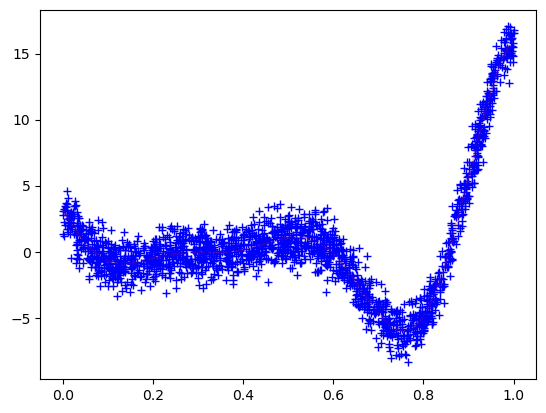

In [41]:
with torch.no_grad():
    ypred, yvar = forward(xtr, ytr, xte, kernel,log_beta)
plt.errorbar(xte.cpu().numpy().reshape(100), ypred.detach().cpu().numpy().reshape(100),
             yerr=yvar.cpu().sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.cpu().numpy(), ytr.cpu().numpy(), 'b+')
plt.show()

In [55]:
start_time = time.time()
xtr,ytr=xtr.cpu(),ytr.cpu()
model=cigp(xtr,ytr)
model.train_adam(100,0.1)
end_time = time.time()
standard_gp_time=end_time-start_time

iter 0 nll:1992.60405
iter 10 nll:1004.92647
iter 20 nll:256.53823
iter 30 nll:-130.12748
iter 40 nll:-119.43786
iter 50 nll:-138.47822
iter 60 nll:-151.89502
iter 70 nll:-150.11973
iter 80 nll:-152.93419
iter 90 nll:-152.62457


In [56]:
print(standard_gp_time)

42.24608373641968
